#### 초기 셋팅

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from datetime import datetime as dt, timedelta, date
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import calendar
from scipy.stats import mannwhitneyu, ttest_ind, ttest_rel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols


# plotting options
%matplotlib inline

#### 데이터 불러오기

In [2]:
bookings=pd.read_csv("D:/사용자/Desktop/2022-2/hotel_bookings.csv",parse_dates=True)

#### 사전 탐색

In [3]:
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

#### Wrangling /cleaning (데이터 정리 및 정제)

In [4]:
# 시계열 데이터 그릴 목적으로 미리 정리
ordered_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", 
                 "October", "November", "December"]

ordered_rooms = np.sort(bookings.assigned_room_type.unique())

# month mapping (숫자를 월 이름으로)
month_mapping = {v: k for k,v in enumerate(calendar.month_name)}

In [5]:
# 도착(연,월,일)
bookings["arrival_date"] = bookings["arrival_date_year"].astype(str) + bookings["arrival_date_month"] + bookings["arrival_date_day_of_month"].astype(str)
bookings["arrival_date"] = bookings["arrival_date"].apply(lambda x: dt.strptime(x, "%Y%B%d"))

# (평일 + 주말) 체류 기간
bookings['length_of_stay'] = bookings['stays_in_weekend_nights'] + bookings['stays_in_week_nights']

# 체류 기간의 간격
bookings['los_int'] = pd.cut(bookings.length_of_stay, bins = range(1,30, 2))

# 출발일
bookings['departure_date'] = bookings.apply(lambda x: x.arrival_date + timedelta(days = x.length_of_stay), axis = 1)

# 예약일
bookings['booking_date'] = bookings.apply(lambda x: x.arrival_date - timedelta(days = x.lead_time), axis = 1)
bookings['booking_month'] = bookings['booking_date'].apply(lambda x: x.strftime('%b'))

# revenue = adr * length of stay  : 수익 = (일일 숙박 가격) x (숙박 일 수)
bookings['revenue'] = [los * adr if los > 0 else adr for los, adr in zip(bookings['length_of_stay'], bookings['adr'])]

# lead_time_weeks (평일 lead_time)
bookings['lead_time_weeks'] = bookings['lead_time'].apply(lambda x: x // 7)

# weekday check in and check out
bookings['weekday_checkin'] = bookings['arrival_date'].dt.weekday
bookings['weekday_checkout'] = bookings['departure_date'].dt.weekday


# 'group' 변수(열) 생성
bookings['group'] = bookings.market_segment == "Groups"

#### 데이터 분할 :  (City hotel) , (Resort hotel)

In [6]:
city = bookings[bookings["hotel"] == "City Hotel"]
resort = bookings[bookings["hotel"] == "Resort Hotel"]

#### 취소된 예약을 filtering 

In [7]:
def filter_confirmed(dat):
    
    '''
    Dataframe(dat)에서 확인된 예약을 filtering.
    assume : dat에서 취소되지 않은 예약의 경우 0,
            취소된 예약의 경우 1인 'is_cancelled' column에 존재.
            
    input
    - dat : filtering 할 Dataframe
    
    output
    - 취소된 예약이 제거된 입력 Dataframe의 filtering된 version.
    
    '''
    return dat[dat['is_canceled'] == 0]

In [8]:
bookings_confirmed = filter_confirmed(bookings)
city_confirmed = filter_confirmed(city).reset_index()
resort_confirmed = filter_confirmed(resort).reset_index()

## How strong is the seasonality?

In [9]:
def get_daily_data(booking_data, group_vars = None):
    
    
    '''
    bookings dataset을 도착 날짜가 아닌 숙박 날짜인 일별 dataset으로 집계한다.
    
    input
    -booking_data : Dataframe(예약 포함)
    
    output
    - 매일 집계된 데이터가 포함된 Dataframe
    - group_vars : 일별 데이터 계산할 때 그룹화에 사용되는 선택적 추가적인 변수
    '''
    
    # Dataframe -> list 
    # with the function arrival_to_stay
    expanded_data_list = [arrival_to_stay(booking_data.loc[row, :], group_vars) for row in range(booking_data.shape[0])]
    
    # 이전 list를 하나의 Dataframe에 연결
    stay_data = pd.concat(expanded_data_list, axis = 0)
    
    group_list =['stay_date']
    
    if group_vars is not None:
        group_list.extend(group_vars)

    
    # 날짜별 데이터를 그룹화하여, roomnight 과 revenue를 얻는다.
    daily_data = stay_data.groupby(group_list).agg({'roomnights':'sum',
                                                     'revenue': 'sum'}).reset_index()
    
    # computes adr from roomnights and reveue
    daily_data['adr'] = daily_data['revenue'] / daily_data['roomnights']
    
    # creates month and week columns
    daily_data['stay_month'] = daily_data['stay_date'].dt.month
    daily_data['stay_week'] = daily_data['stay_date'].dt.week
    
    # creates DateTime Index with stay_date
    daily_data = daily_data.set_index('stay_date')
    
    return daily_data

In [10]:
def arrival_to_stay(ser, group_vars = None):
    
    '''
    도착 날짜와 숙박 기간이 있는 Dataframe 만들기
    (ex. 숙박 기간이 3인 경우 Dataframe은 3개의 row를 가짐)
    
    input
    - ser: load 되거나 생성된 예약 Dataframe의 행
    -group_vars: stay_date 외에 Dataframe에 포함할 추가적인 column
    
    ouput
    - Pandas Dataframe
    '''
        
    # lenght of stay 추출
    los = ser['length_of_stay']
    
    # intiial stay date 가져오기
    arrival_date = ser['arrival_date']
    
    #  arrival_date를 첫번째 날짜로 사용하는 연속적인 날짜 범위를 만들기.
    #  arrival_date + los를 마지막 날짜로 지정.
    days = pd.date_range(arrival_date, arrival_date + timedelta(days = int(los - 1 * (los > 0))))
    
    # 반복적인 value가 있는 array를 만들어주는 helper function
    def expand_point(point):
        return np.repeat(ser[point], los + (los == 0) * 1)
    

    
    # stay_message 및 반복적인 value를 사용해서 Dataframe 생성
    dat = pd.DataFrame(data = {'stay_date': days,
                               'roomnights': np.repeat((los > 0) * 1, los + (los == 0) * 1),
                               'revenue': expand_point("adr")
                                  }
                      )
    
    
    # Dataframe에 추가적인 열을 포함
    df_add_cols = pd.DataFrame()
    
    if group_vars is not None:
        for name in group_vars:
            df_add_cols[name] = expand_point(name)
    
    dat = pd.concat([dat, df_add_cols], axis = 1) 
 
    return dat
    

In [11]:
# getting daily data
bookings_daily = get_daily_data(bookings_confirmed.reset_index(), ["hotel"])
resort_daily = bookings_daily[bookings_daily.hotel == "Resort Hotel"]
city_daily = bookings_daily[bookings_daily.hotel == "City Hotel"]

C:\Users\yooob\AppData\Local\Temp\ipykernel_2172\413709719.py:37: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  daily_data['stay_week'] = daily_data['stay_date'].dt.week


In [12]:
# 예약을 위한 일별 데이터를 정리
bookings_daily_long = pd.melt(bookings_daily.reset_index(), 
                  id_vars = ['stay_date', 'hotel'], 
                  value_vars = ['roomnights', 'revenue', 'adr'],
                  var_name = 'kpi')

# kpi에 대한 이동 평균 계산
bookings_daily_long['rolling_value'] = bookings_daily_long.groupby(['hotel', 'kpi'])['value'].apply(lambda x: x.rolling(window = 7).mean())
bookings_daily_long['kpi'] = bookings_daily_long['kpi'].apply(lambda x: str.upper(x))
bookings_daily_long.reset_index(inplace = True)

In [13]:
bookings_daily.head()

,hotel,roomnights,revenue,adr,stay_month,stay_week
stay_date,,,,,,
2015-07-01,City Hotel,65,6180.00,95.076923,7,27
2015-07-01,Resort Hotel,36,3356.83,93.245278,7,27
2015-07-02,City Hotel,66,6238.67,94.525303,7,27
2015-07-02,Resort Hotel,64,6251.33,97.677031,7,27
2015-07-03,City Hotel,13,991.94,76.303077,7,27


In [14]:
bookings_daily_long.head(15)

,index,stay_date,hotel,kpi,value,rolling_value
0,0,2015-07-01,City Hotel,ROOMNIGHTS,65.0,NaN
1,1,2015-07-01,Resort Hotel,ROOMNIGHTS,36.0,NaN
2,2,2015-07-02,City Hotel,ROOMNIGHTS,66.0,NaN
3,3,2015-07-02,Resort Hotel,ROOMNIGHTS,64.0,NaN
4,4,2015-07-03,City Hotel,ROOMNIGHTS,13.0,NaN
5,5,2015-07-03,Resort Hotel,ROOMNIGHTS,81.0,NaN
6,6,2015-07-04,City Hotel,ROOMNIGHTS,22.0,NaN
7,7,2015-07-04,Resort Hotel,ROOMNIGHTS,108.0,NaN
8,8,2015-07-05,City Hotel,ROOMNIGHTS,12.0,NaN
9,9,2015-07-05,Resort Hotel,ROOMNIGHTS,122.0,NaN


### Yearly Seasonality
#### Raw data and 7-day Moving Average Plot of the kpi(adr,roomnights,revenue)

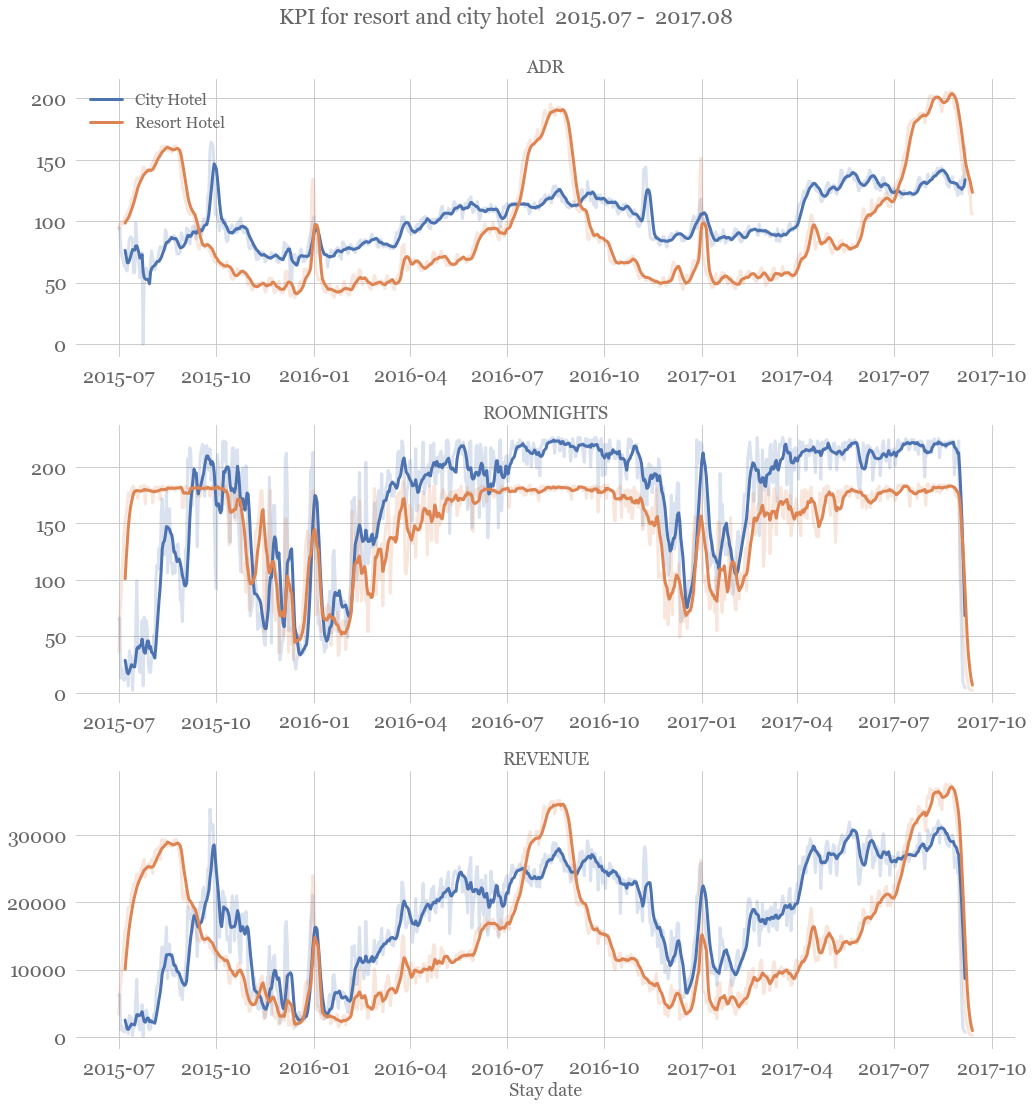

In [15]:
# set style: font sizes, family. etc
sns.set( style = "whitegrid", font_scale = 1.8,
        font = "Georgia", rc={"lines.linewidth": 3,
                              "font.size": 18, 
                              "axes.labelsize": 18, 
                              'legend.fontsize': 16,
                              'text.color': '.4',
                             'xtick.color': '.4',
                             'ytick.color': '.4',
                             'axes.labelcolor': '.4'})

g = sns.FacetGrid(bookings_daily_long, col="kpi", col_wrap = 1, col_order = ["ADR", "ROOMNIGHTS", "REVENUE"],
                  hue = "hotel", sharex = False, sharey = False, aspect = 3, height = 5, legend_out = False)

# 두 호텔의 series 그리기
g.map_dataframe(sns.lineplot, x = "stay_date", y = "value", alpha = 0.2)
g.map_dataframe(sns.lineplot, x = "stay_date", y = "rolling_value").set_axis_labels("Stay date","").set_titles("{col_name}")
g.fig.suptitle("KPI for resort and city hotel  2015.07 -  2017.08", y = 1.03)
g.add_legend(title = "", frameon=False)
sns.despine(bottom = True, left = True)


### Seasonality strength

In [17]:
def resample_time_kpis(dat, order):
    
    '''
    Datetime 인덱스를 사용하여 지정된 예약 Dataframe에서 (revenue, roomnights, adr)를 계산하고
    Dataframe을 'order'에 명시된 순서로 resampling
    
    위의 function과의 차이점은 날짜별로 그룹화할 때 Datetime 인덱스가 존재한다는 것.
    time series operations과 같은 시계열 연산을 수행할 수 있다.
    
    input
    - dat : Datetime 인덱스가 있는 Dataframe
    - order : order resampling
    
    output
    - Datetime 인덱스로 이루어진 Dataframe에 'room nights', 'revenue' 및 'adr' 열이 있음.
    
    ''' 
    
    # computes roomnights and revenue
    dat = dat.resample(order).agg({'roomnights': 'sum', 'revenue': 'sum'})
    
    # computes adr
    dat['adr'] = dat['revenue'] / dat['roomnights']
    
    return dat

In [18]:
# main kpi에 대한 월별 시계열 가져오기
resort_kpi_time_month = resample_time_kpis(resort_daily, 'MS')
city_kpi_time_month = resample_time_kpis(city_daily, 'MS')

In [19]:
dec_resort_adr = sm.tsa.seasonal_decompose(resort_kpi_time_month[['adr']])
dec_city_adr = sm.tsa.seasonal_decompose(city_kpi_time_month[['adr']])

dec_resort_rn = sm.tsa.seasonal_decompose(resort_kpi_time_month[['roomnights']])
dec_city_rn = sm.tsa.seasonal_decompose(city_kpi_time_month[['roomnights']])

dec_resort_rev = sm.tsa.seasonal_decompose(resort_kpi_time_month[['revenue']])
dec_city_rev = sm.tsa.seasonal_decompose(city_kpi_time_month[['revenue']])

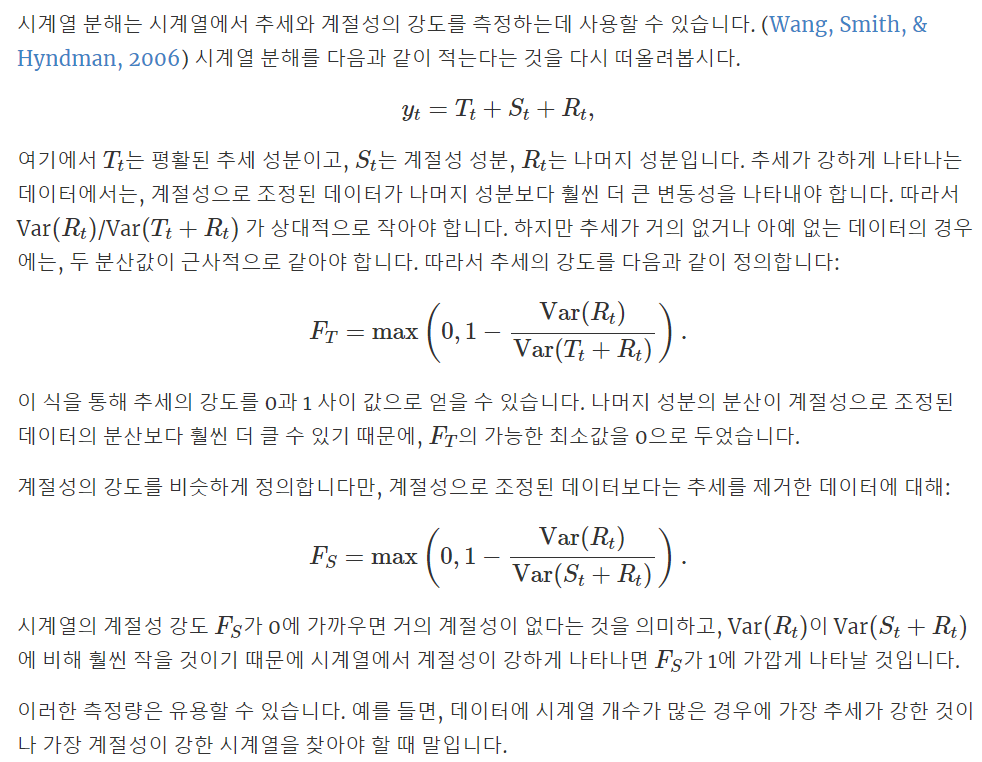

In [20]:
def compute_seasonality_strength(decomp_series):
    
    '''
    분해된 시계열에서 seasonality strengh를 계산함
    
    input
    - decomp_series : 계절 데이터가 있는 statsmodels.tsa.models 개체
    
    output
    - numeric score
    '''
    
    return 1 - np.var(decomp_series.resid) / (np.var(decomp_series.resid) + np.var(decomp_series.seasonal))

In [21]:
# print adr seasonality strength for both hotels
print("ADR resort seasonality: " + str(round(compute_seasonality_strength(dec_resort_adr), 3)))
print("ADR city seasonality: " + str(round(compute_seasonality_strength(dec_city_adr), 3)))

ADR resort seasonality: 0.993
ADR city seasonality: 0.944


In [22]:
# print roomnights seasonality strength for both hotels
print("Roomnights resort seasonality: " + str(round(compute_seasonality_strength(dec_resort_rn), 3)))
print("Roomnights city seasonality: " + str(round(compute_seasonality_strength(dec_city_rn), 3)))

Roomnights resort seasonality: 0.975
Roomnights city seasonality: 0.998


In [23]:
# print revenue seasonality strength for both hotels
print("Revenue resort seasonality: " + str(round(compute_seasonality_strength(dec_resort_rev), 3)))
print("Revenue city seasonality: " + str(round(compute_seasonality_strength(dec_city_rev), 3)))

Revenue resort seasonality: 0.999
Revenue city seasonality: 0.988


### Weekdays vs weekends

In [24]:
# 일별 dataset에서 'is_weekend ' 변수(열) 생성
bookings_daily = bookings_daily.reset_index()
bookings_daily['is_weekend'] = bookings_daily['stay_date'].apply(lambda x: x.weekday() in [5, 6])

In [25]:
bookings_daily

,stay_date,hotel,roomnights,revenue,adr,stay_month,stay_week,is_weekend
0,2015-07-01,City Hotel,65,6180.00,95.076923,7,27,False
1,2015-07-01,Resort Hotel,36,3356.83,93.245278,7,27,False
2,2015-07-02,City Hotel,66,6238.67,94.525303,7,27,False
3,2015-07-02,Resort Hotel,64,6251.33,97.677031,7,27,False
4,2015-07-03,City Hotel,13,991.94,76.303077,7,27,False
...,...,...,...,...,...,...,...,...
1600,2017-09-09,Resort Hotel,7,946.52,135.217143,9,36,True
1601,2017-09-10,Resort Hotel,3,365.43,121.810000,9,36,True
1602,2017-09-11,Resort Hotel,3,365.43,121.810000,9,37,False
1603,2017-09-12,Resort Hotel,2,211.86,105.930000,9,37,False


In [27]:
bookings_daily = bookings_daily.reset_index()

# Dataframe 으로 정리
bookings_daily_long_weekend = pd.melt(bookings_daily, 
                              id_vars = ['stay_date', 'hotel', 'is_weekend'], 
                              value_vars = ['adr', 'roomnights', 'revenue'], 
                              var_name = 'kpi'
                             )
# True:주말, False:주중
bookings_daily_long_weekend['is_weekend'] = bookings_daily_long_weekend['is_weekend'].replace({True: "Weekend", False: "Weekday"})

bookings_daily_long_weekend['kpi'] = bookings_daily_long_weekend['kpi'].str.upper()

Text(0.5, 1.03, 'Main KPIs distribution for weekdays and weekends')

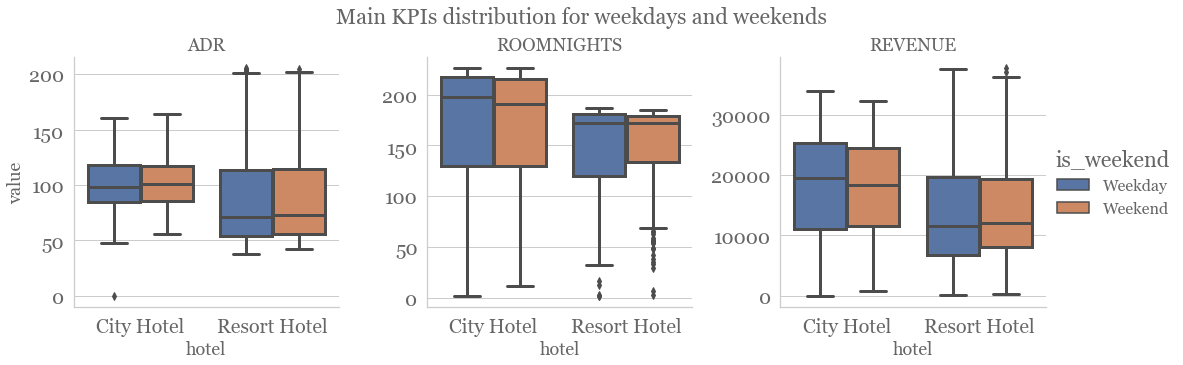

In [28]:
# Boxplot 그리기
g = sns.catplot(x = "hotel", 
            y = "value", 
            data = bookings_daily_long_weekend, 
            hue = "is_weekend", 
            col = "kpi", 
            kind = "box",
            sharey = False).set_titles("{col_name}")

g.fig.suptitle("Main KPIs distribution for weekdays and weekends", y = 1.03)

###### kpi(adr,roomnights,revenue)에 대한 평일과 주말에 차이가 거의 없음을 확인할 수 있었다.